1) Clone https://github.com/adamnguyenitvn/UIT_bigdata_labs_2019

2) Open Forecasting.ipynb

3) Make a copy of Forecasting.ipynb, name it with your studentID.ipynb

4) Do the exercise

5) Push your Jupyter notebook to github

# Nguyen Minh Hieu 16520399

Note that you should use Python 3 for all exercises.

In [44]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [45]:
df = pd.read_csv('data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

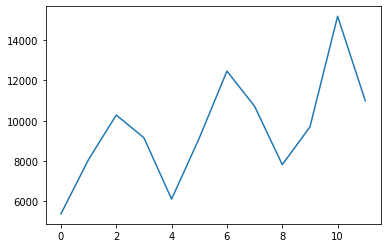

In [46]:
plt.plot(df['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

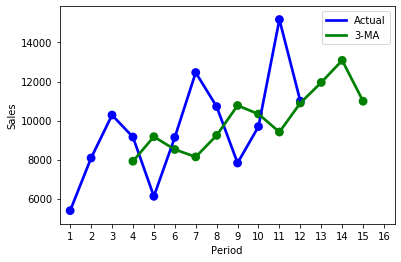

In [47]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    # TODO: Add your code here
    for i in range(1,k+1):
        moving_average_df = moving_average_df.append({
        "Period":i,
        "Sales": np.NaN
    }, ignore_index=True)
    for i in range (k+1,17):
        moving_average_df = moving_average_df.append({
        "Period":i,
        "Sales": df.loc[i-4:i-2,'Sales'].mean()
    }, ignore_index=True)
    # End of your coding
    moving_average_df['Period'] = moving_average_df['Period'].astype(int) 
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

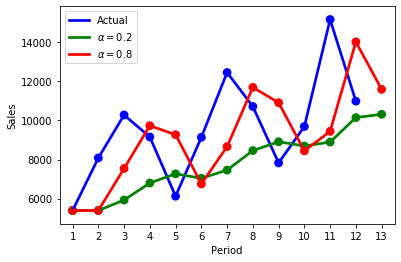

In [48]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df.loc[0,'Sales']]
    # TODO: Add your code here
    for i in range(2, len(df)+2):
        es_df.loc[i-1] = [i, alpha*df.loc[i-2,'Sales']+ (1-alpha)*es_df.loc[i-2,'Sales']]
    es_df['Period'] = es_df['Period'].astype(int)
    # End of your coding
    return es_df


f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

### Using linear regression

In [49]:
def linear_regression(df):
    #y = a+b*x
    x = df['Period']
    y = df['Sales']
    # TODO: Add your code here
    xy = (x*y).sum()
    x2 = (x*x).sum()
    xmean = x.mean()
    ymean = y.mean()
    n = len(df)
    b = (xy - n*xmean*ymean)/ (x2- n*xmean**2)
    a = ymean - b*xmean
    # End of your coding
    return a,b

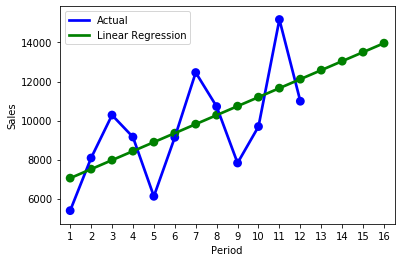

In [50]:
a,b = linear_regression(df)
linear_df = pd.DataFrame(columns=['Period','Sales'])
for m in range(1, 17):
    sale = a + b * m
    linear_df.loc[m-1] = [m,sale]
linear_df['Period'] = linear_df['Period'].astype(int)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=linear_df, color='g')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", "Linear Regression"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality (Optional)

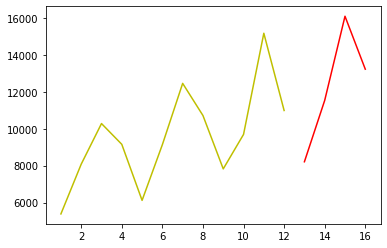

In [87]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    #init var
    index_df = df
    index_df['index'] = [0 for i in range(1,13)]
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    season_avg = []
    #add index in first 12 periods
    for i in range(0,len(df),4):
        avg = new_df[i:i+4]['Sales'].mean()
        season_avg.append(avg)
        for j in range(i,i+4):
            index_df.loc[j,'index'] = index_df.loc[j,'Sales']/ avg
    #Caculate the average sales of season IV
    predict_avg = season_avg[-1] + (season_avg[-1] - season_avg[0])/2
    #Forecast season IV
    for i in range (len(df),months[-1]):
        forecast_df.loc[i] = [i+1, predict_avg * index_df[i-12::4]['index'].mean()]
    forecast_df['Period'] = forecast_df['Period'].astype(int)
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

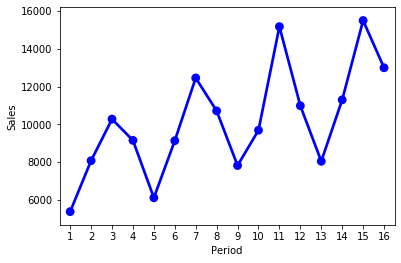

In [80]:
eval_df = pd.read_csv('actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True, sort=False)
sns.pointplot(x='Period', y='Sales', data=eval_df, color='b')

In [104]:
Method_Error = {}
MAD = np.absolute(eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16]).mean()
Method_Error['3-MA'] = MAD
print("MAD of {0}: {1}".format("3-MA", MAD))
#
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
Method_Error['Exponential smoothing with alpha=0.2'] = MAD
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
#
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
Method_Error['Exponential smoothing with alpha=0.8'] = MAD
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
#
MAD = np.absolute(eval_df['Sales'][12:16] - linear_df['Sales'][12:16]).mean()
Method_Error['Linear Regression'] = MAD
print("MAD of {0}: {1}".format("Linear Regression", MAD))
#
MAD = np.absolute(eval_df['Sales'][12:16] - season_df['Sales'][0:4]).mean()
Method_Error['Seasonality'] = MAD
print("MAD of {0}: {1}".format("Seasonality Method", MAD))
Method_Error = sorted(Method_Error.items(), key = lambda x:x[1])

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Linear Regression: 2309.1480186480185
MAD of Seasonality Method: 306.5


In [105]:
MSE = (eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df['Sales'][12:16] - linear_df['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Linear Regression", MSE))
MSE = (eval_df['Sales'][12:16] - season_df['Sales'][0:4])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Linear Regression: 7123661.909756519
MSE of Seasonality Method: 123268.78553061216


# Give your conclusion about the above forecastings

In [110]:
"{} method has the lowest error while the highest error belongs to {} method".format(Method_Error[0][0], Method_Error[4][0])

'Seasonality method has the lowest error while the highest error belongs to Exponential smoothing with alpha=0.8 method'